# Evaluate ICL Model on the Omniglot Classification Dataset

In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.datasets.wrappers import (
    ContextDataset,
    StandardSupervisedDataset,
    FixedLengthContextDataset,
    RepeatedContextDataset,
)
from jaxl.models import (
    load_config,
    load_model,
    get_model,
    get_activation
)
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict, get_device

import _pickle as pickle
import copy
import jax
import jax.random as jrandom
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.datasets as torch_datasets

from collections import OrderedDict
from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [2]:
# device = "cpu"
device = "gpu:2"
get_device(device)

In [3]:
doc_width_pt = 750.0

base_path = "/home/bryanpu1/projects/icl/jaxl/"
data_path = os.path.join(base_path, "data")
log_path = os.path.join(base_path, "jaxl/logs")
project_name = "icl-omniglot"
run_name = "context_len_16-num_blocks_8-02-06-24_20_18_16-14a646b2-e6bc-41e9-8b98-c6573a79cd75"

learner_path = os.path.join(
    log_path,
    project_name,
    run_name,
)

exp_name = "-".join(run_name.split("-")[:-8])

# Experiment Configuration

In [4]:
config_dict, config = load_config(learner_path)

In [5]:
config

namespace(logging_config=namespace(save_path='./logs/icl-omniglot',
                                   experiment_name='context_len_16-num_blocks_8',
                                   log_interval=10,
                                   checkpoint_interval=100),
          model_config=namespace(architecture='icl_gpt',
                                 num_contexts=16,
                                 num_blocks=8,
                                 num_heads=1,
                                 embed_dim=32,
                                 positional_encoding=namespace(type='default',
                                                               kwargs=namespace(embed_dim=32,
                                                                                max_len=17)),
                                 input_tokenizer=namespace(type='cnn',
                                                           kwargs=namespace(features=[32,
                                                              

# Load Dataset and Model

In [6]:
train_dataset = get_dataset(
    config.learner_config.dataset_config,
    config.learner_config.seeds.data_seed,
)

Files already downloaded and verified
Loading from /home/bryanpu1/projects/icl/data/omniglot_icl/omniglot_finegrain-background_True-num_sequences_500000-sequence_length_30-random_label_False-seed_0.pkl


In [7]:
params, model = load_model(
    train_dataset.input_dim,
    train_dataset.output_dim,
    learner_path,
    -1
)

/home/bryanpu1/.conda/envs/icl/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1475: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [8]:
context_len = config.model_config.num_contexts
num_samples_per_task = train_dataset._dataset.sequence_length - 1
sequence_length = train_dataset._dataset.sequence_length
num_tasks = 100
num_workers = 4

print(num_samples_per_task, num_tasks, sequence_length, context_len)

29 100 30 16


In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

# Helper Functions

In [10]:
def get_preds_labels(data_loader, num_tasks):
    all_preds = []
    all_labels = []
    all_outputs = []

    for batch_i, samples in enumerate(data_loader):
        if batch_i >= num_tasks:
            break

        (context_inputs, context_outputs, queries, one_hot_labels) = samples

        outputs, _ = model.forward(
            params[CONST_MODEL_DICT][CONST_MODEL],
            queries.numpy(),
            {
                CONST_CONTEXT_INPUT: context_inputs.numpy(),
                CONST_CONTEXT_OUTPUT: context_outputs.numpy(),
            },
        )
        preds = np.argmax(outputs, axis=-1)
        labels = np.argmax(one_hot_labels, axis=-1)
        all_preds.append(preds)
        all_labels.append(labels)
        all_outputs.append(outputs)

    all_outputs = np.concatenate(all_outputs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels, all_outputs

def print_performance(
    all_preds, all_labels, sequence_length, context_len, output_dim,
):
    conf_mat = confusion_matrix(all_labels, all_preds, labels=np.arange(output_dim))
    acc = np.trace(conf_mat) / np.sum(conf_mat) * 100
    print("Pretraining Accuracy: {}".format(acc))

    reshaped_preds = all_preds.reshape((-1, sequence_length - 1))
    reshaped_labels = all_labels.reshape((-1, sequence_length - 1))
    for curr_context_len in range(context_len):
        if curr_context_len < context_len - 1:
            curr_preds = reshaped_preds[:, curr_context_len]
            curr_labels = reshaped_labels[:, curr_context_len]
        else:
            curr_preds = reshaped_preds[:, curr_context_len:]
            curr_labels = reshaped_labels[:, curr_context_len:]

        curr_preds = curr_preds.reshape(-1)
        curr_labels = curr_labels.reshape(-1)

        curr_conf_mat = confusion_matrix(
            curr_labels, curr_preds, labels=np.arange(output_dim)
        )
        curr_acc = np.trace(curr_conf_mat) / np.sum(curr_conf_mat) * 100
        print(
            "Pretraining Accuracy with Context Length {} (Num Samples: {}): {}".format(
                curr_context_len + 1, np.sum(curr_conf_mat), curr_acc
            )
        )

# Check Dataset

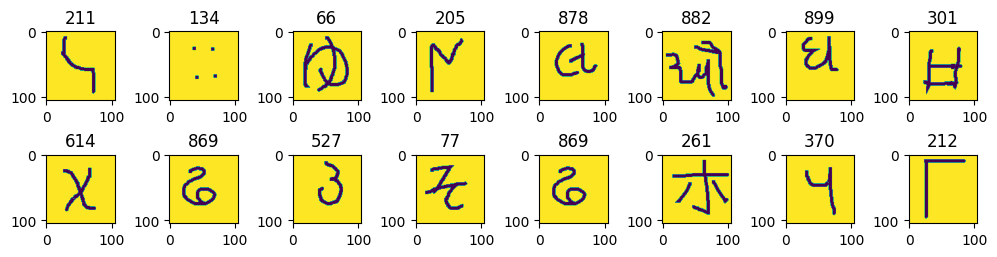

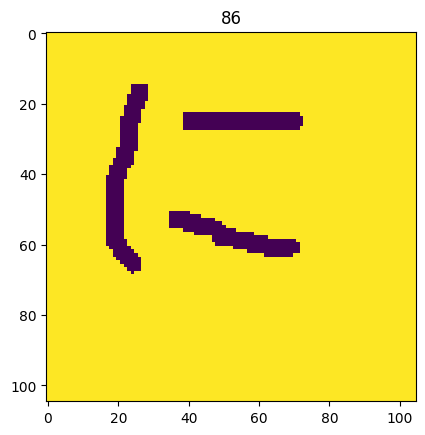

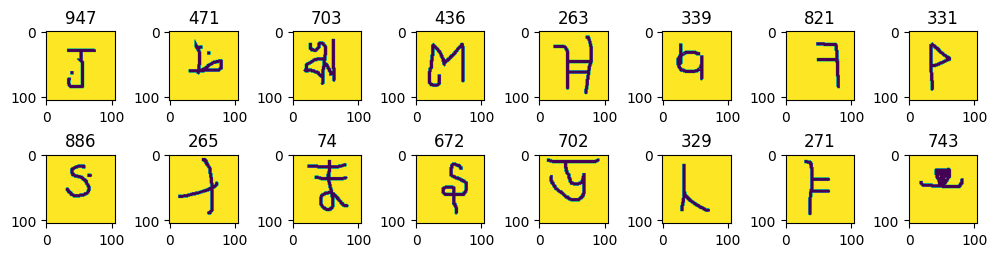

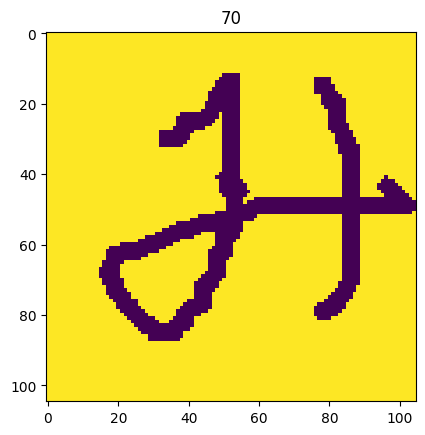

In [14]:
for task_i in range(2):
    ci, co, q, l = train_dataset[task_i * num_samples_per_task + num_samples_per_task - 1]

    nrows = 2
    ncols = 8
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    for idx, (img, label) in enumerate(zip(ci, co)):
        axes[idx // ncols, idx % ncols].imshow(img)
        axes[idx // ncols, idx % ncols].set_title(np.argmax(label))
    plt.show()
    plt.close()

    plt.imshow(q[0])
    plt.title(np.argmax(l))
    plt.show()
    plt.close()

# Get Training Performance

In [11]:
train_preds, train_labels, train_outputs = get_preds_labels(train_loader, num_tasks)
pickle.dump(
    [train_preds, train_labels, train_outputs],
    open("train_prediction_result.pkl", "wb")
)



/home/bryanpu1/.conda/envs/icl/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [12]:
print_performance(
    train_preds,
    train_labels,
    sequence_length,
    context_len,
    train_dataset.output_dim[0],
)

Pretraining Accuracy: 0.2413793103448276
Pretraining Accuracy with Context Length 1 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 2 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 3 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 4 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 5 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 6 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 7 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 8 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 9 (Num Samples: 100): 2.0
Pretraining Accuracy with Context Length 10 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 11 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 12 (Num Samples: 100): 2.0
Pretraining Accuracy with Context Length 13 (Num Samples: 100): 0.0
Pretraining Accuracy with Context Length 14 (Num Samples: 100): 0.0
Pretraining Accu

# In-distribution Test Data

In [ ]:
num_in_dist_test_tasks = 30
in_dist_test_data_seed = 1000

In [ ]:
config.learner_config.dataset_config

In [ ]:
in_dist_test_config_dict = copy.deepcopy(config_dict["learner_config"]["dataset_config"])
in_dist_test_config_dict["dataset_kwargs"]["num_sequences"] = num_in_dist_test_tasks
in_dist_test_config = parse_dict(in_dist_test_config_dict)

In [ ]:
in_dist_test_dataset = get_dataset(
    in_dist_test_config,
    in_dist_test_data_seed,
)

In [ ]:
in_dist_test_loader = DataLoader(
    in_dist_test_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [ ]:
in_dist_test_preds, in_dist_test_labels, in_dist_test_outputs = get_preds_labels(in_dist_test_loader, num_in_dist_test_tasks)
pickle.dump(
    [in_dist_test_preds, in_dist_test_labels, in_dist_test_outputs],
    open("in_dist_test_prediction_result.pkl", "wb")
)

In [ ]:
print_performance(
    in_dist_test_preds,
    in_dist_test_labels,
    sequence_length,
    context_len,
    in_dist_test_dataset.output_dim[0],
)

# Out-of-class Test Data
This checks out-of-class generalization (i.e. heldout classes)

In [ ]:
num_ooc_test_tasks = 30
ooc_test_data_seed = 1000

In [ ]:
ooc_test_config_dict = copy.deepcopy(config_dict["learner_config"]["dataset_config"])
ooc_test_config_dict["dataset_kwargs"]["split"] = "test"
ooc_test_config_dict["dataset_kwargs"]["num_sequences"] = num_ooc_test_tasks
ooc_test_config = parse_dict(ooc_test_config_dict)

In [ ]:
ooc_test_dataset = get_dataset(
    ooc_test_config,
    ooc_test_data_seed,
)

In [ ]:
ooc_test_loader = DataLoader(
    ooc_test_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [ ]:
ooc_test_preds, ooc_test_labels, ooc_test_outputs = get_preds_labels(ooc_test_loader, num_ooc_test_tasks)
pickle.dump(
    [ooc_test_preds, ooc_test_labels, ooc_test_outputs],
    open("ooc_test_prediction_result.pkl", "wb")
)

In [ ]:
print_performance(
    ooc_test_preds,
    ooc_test_labels,
    sequence_length,
    context_len,
    ooc_test_dataset.output_dim[0],
)

# Relabel Test Data
Maps the labels to a constrained subset

In [ ]:
num_remap_test_tasks = 30
remap_test_data_seed = 1000

In [ ]:
remap_test_config_dict = copy.deepcopy(config_dict["learner_config"]["dataset_config"])
remap_test_config_dict["dataset_kwargs"]["split"] = "test"
remap_test_config_dict["dataset_kwargs"]["remap"] = True
remap_test_config_dict["dataset_kwargs"]["num_sequences"] = num_remap_test_tasks
remap_test_config = parse_dict(remap_test_config_dict)

In [ ]:
remap_test_dataset = get_dataset(
    remap_test_config,
    remap_test_data_seed,
)

In [ ]:
remap_test_loader = DataLoader(
    remap_test_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [ ]:
remap_test_preds, remap_test_labels, remap_test_outputs = get_preds_labels(remap_test_loader, num_remap_test_tasks)
pickle.dump(
    [remap_test_preds, remap_test_labels, remap_test_outputs],
    open("remap_test_prediction_result.pkl", "wb")
)

In [ ]:
print_performance(
    remap_test_preds,
    remap_test_labels,
    sequence_length,
    context_len,
    remap_test_dataset.output_dim[0],
)